# Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

%matplotlib inline

In [ ]:
# Install Kaggle API
!pip install -q kaggle

In [ ]:
# Upload Kaggle JSON file
from google.colab import files
files.upload()

In [ ]:
# Copy file to new directory
try: 
  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
except FileExistsError:
  pass

In [ ]:
# Download the dataset from Kaggle
!kaggle competitions download -c job-recommendation

In [ ]:
# Check downloaded files
!ls /content

In [ ]:
# Extract zipped files
!unzip /content/jobs.zip

# Exploratory Data Analysis

In [ ]:
jobs = pd.read_csv('/content/jobs.tsv', delimiter='\t',encoding='utf-8', error_bad_lines=False)

b'Skipping line 122433: expected 11 fields, saw 12\n'
b'Skipping line 602576: expected 11 fields, saw 12\n'
b'Skipping line 990950: expected 11 fields, saw 12\n'
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Check job availability by country
job_by_country = jobs.groupby(['Country']).size().reset_index(name='Job Amount').sort_values('Job Amount',
                                                                                               ascending=False)
job_by_country.head()

,Country,Job Amount
59,US,1090462
4,AF,560
19,CZ,193
40,MX,93
52,TR,81


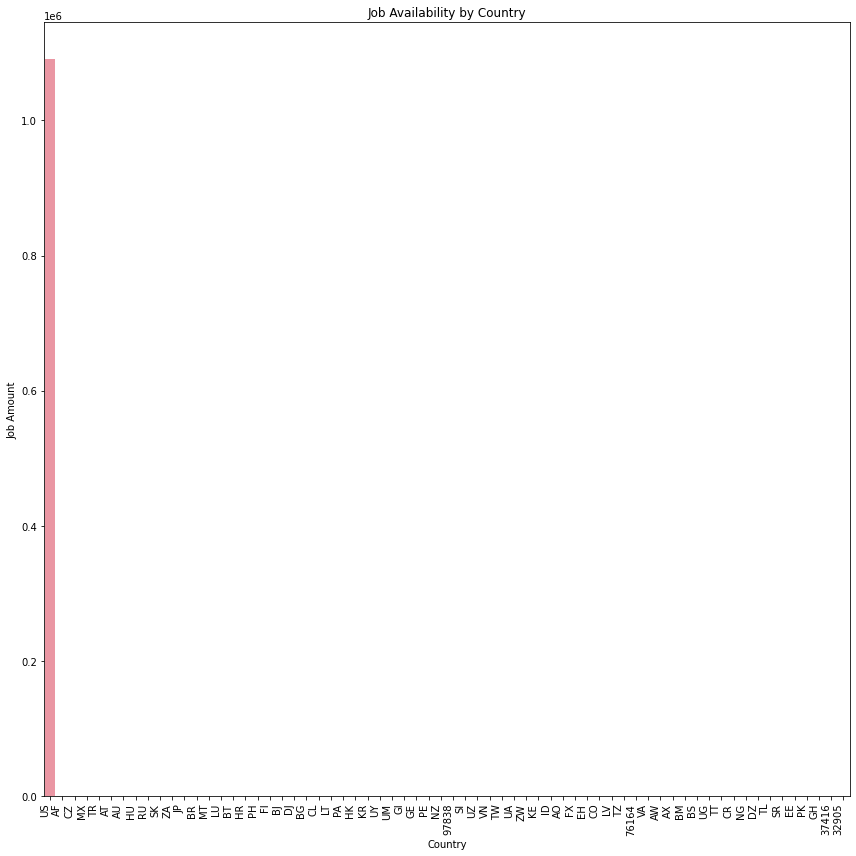

In [ ]:
# Plot a graph
plt.figure(figsize=(12,12))
ax = sns.barplot(x="Country", y="Job Amount", data=job_by_country)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('Job Availability by Country')
plt.tight_layout()
plt.show()

Since the majority of job availability is in the US, we will only use job listings from the US for training.


In [ ]:
# Filter job availability to US
jobs_filtered = jobs.loc[jobs['Country']=='US']

In [ ]:
# Check the filtered jobs
jobs_filtered.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


In [ ]:
# Only take columns 0-6 into consideration
jobs_final = jobs_filtered.iloc[0:10000,0:6]
jobs_final.head()

,JobID,WindowID,Title,Description,Requirements,City
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando


In [ ]:
# Replace NaN values with empty strings
jobs_final['Title'] = jobs_final['Title'].fillna('')
jobs_final['Description'] = jobs_final['Description'].fillna('')
jobs_final['Requirements'] = jobs_final['Requirements'].fillna('')
jobs_final['City'] = jobs_final['City'].fillna('')

In [ ]:
# Combine all features into new column
jobs_final['Features'] = jobs_final['Title'] + jobs_final['Description'] + jobs_final['City']
print(jobs_final['Features'])

0        Security Engineer/Technical Lead<p>Security Cl...
1        SAP Business Analyst / WM<strong>NO Corp. to C...
2        P/T HUMAN RESOURCES ASSISTANT<b>    <b> P/T HU...
3        Route Delivery DriversCITY BEVERAGES Come to w...
4        HousekeepingI make  sure every part of their d...
                               ...                        
9998     Sales Representative / Account Manager /  Cust...
9999     Sales Representative / Account Manager /  Cust...
10000    Sales Representative / Account Manager /  Cust...
10001    Sales Representative / Account Manager /  Cust...
10002    Sales Representative / Account Manager /  Cust...
Name: Features, Length: 10000, dtype: object


# Extract Features from Texts using Tfidf

In [ ]:
# Define TFidfVectorizer and create features matrix
tf_idf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tf_idf_matrix = tf_idf.fit_transform(jobs_final['Features'])

In [ ]:
# Check the shape of the matrix
tf_idf_matrix.shape

(10000, 521972)

# Compute Similarity using Cosine Similarity

In [ ]:
# Tfidf gives normalized vectors, linear_kernel will give the same result as cosine_similarity
# linear_kernel is computationally faster
similarity = linear_kernel(tf_idf_matrix, tf_idf_matrix)

In [ ]:
# Check the shape
similarity.shape

(10000, 10000)

In [ ]:
jobs_indices = jobs_final.reset_index()
titles = jobs_indices['Title']
indices = pd.Series(jobs_indices.index, index=jobs_indices['Title'])

# Predict Jobs

In [ ]:
def get_recommendations(title):
    index = indices[title]
    score = list(enumerate(similarity[index]))
    score = sorted(score, key=lambda x: x[1], reverse=True)
    job_indices = [i[0] for i in score]
    return titles.iloc[job_indices[1:11]]

In [ ]:
get_recommendations('SAP Integration Specialist')

5868                       SAP FI/CO Business Analyst
5351    SAP Sales and Distribution Solution Architect
4796       Senior Specialist - SAP Configuration - SD
4991                                 Business Analyst
5159                          SAP Basis Administrator
5100                            QA Performance Tester
5561                                 Business Analyst
5075                                SAP FI Consultant
5890                                 Business Analyst
4849                            Senior Java Developer
Name: Title, dtype: object

In [ ]:
get_recommendations('Security Engineer/Technical Lead')

5906                   Senior Security Engineer
3771                     Director of Admissions
6293    3 Network Architects needed - immediate
3557                          Assistant Manager
401          National Sales & Marketing Manager
2606               Inventory Analyst/ Scheduler
3757                        CLINICAL PHARMACIST
3478           Customer Service Representatives
3558                              Store Manager
2601                     DISTRICT SALES MANAGER
Name: Title, dtype: object

In [ ]:
get_recommendations('Route Delivery Drivers')

4027                                Route Delivery Driver
7517                                Class A Route Drivers
7601                                Delivery Route Driver
7167                                  Delivery Supervisor
2153                        Route Sales Manager - Houston
31                                                DRIVERS
4357    Route Sales Representative Trainee (Lake City Fl)
3776                                 Driver - Class A CDL
26                                    EXPERIENCED ROOFERS
8635                                         DRIVER CDL B
Name: Title, dtype: object